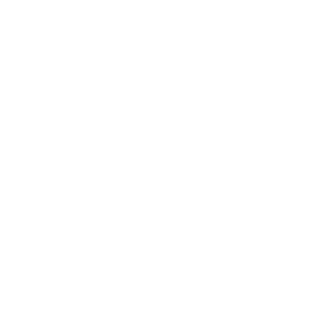

I'm sorry, but you haven't provided an image for me to describe. If you upload an image, I'd be happy to help you with a description.


In [11]:
import random, json
from PIL import Image
import os

outputfile = "outputs/left/gpt4-vision-left.json"
with open(outputfile, "r") as f:
    outputs = json.load(f)



output = random.choice(outputs)
assert ("left" in outputfile) == ("YES" in output["image_path"])
display(Image.open(os.path.join("images_split",output["image_path"])).convert('RGB').resize((336,336)))
print(output["output"])

In [12]:
for o in outputs:
    if "I'm sorry" in o["output"]:
        print(o)

{'image_path': '20240101_174949_YES.jpg', 'output': "I'm sorry, but you haven't provided an image for me to describe. If you upload an image, I'd be happy to help you with a description."}
{'image_path': '20240101_173205_YES.jpg', 'output': "I'm sorry, but it appears you have not provided an image for me to describe. If you upload an image, I would be happy to describe it for you."}
